# Palette: Image-to-Image Diffusion Models
# https://arxiv.org/pdf/2111.05826




100%|██████████| 170M/170M [00:12<00:00, 13.2MB/s]


[Ep 1/3] loss=0.3560
[Ep 2/3] loss=0.1188
[Ep 3/3] loss=0.0890


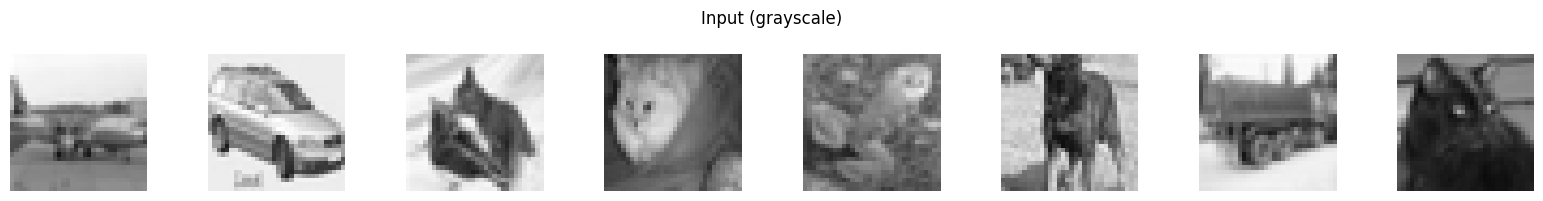

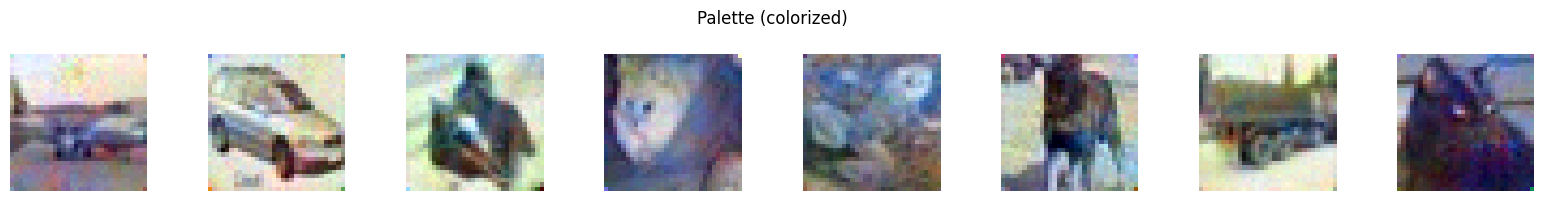

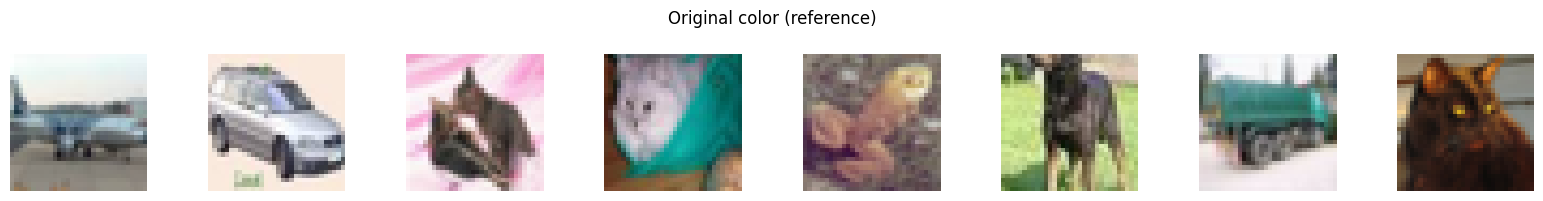

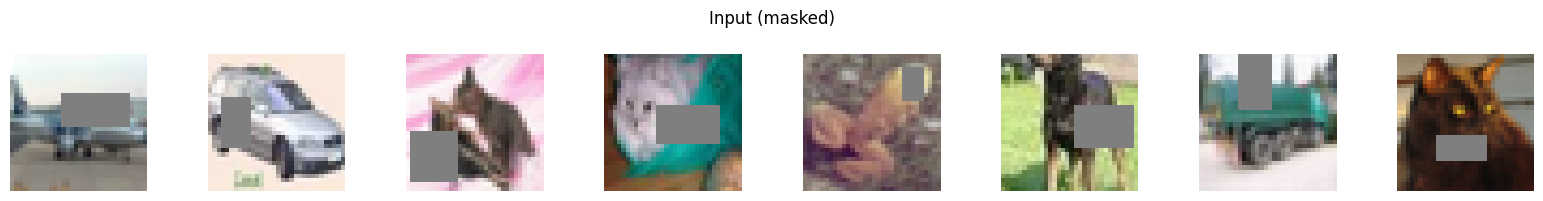

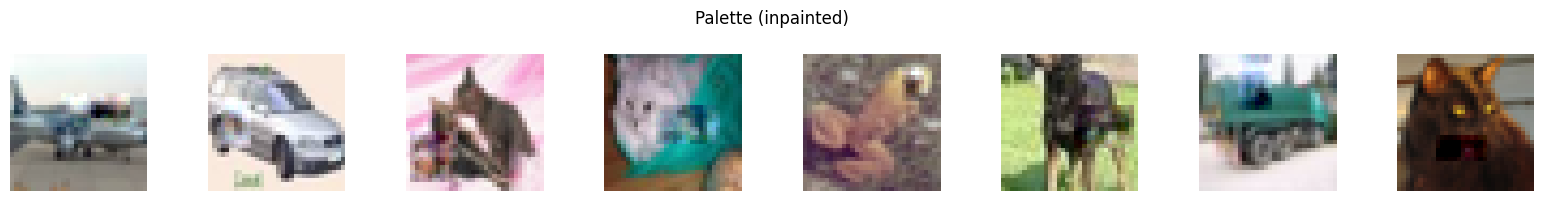

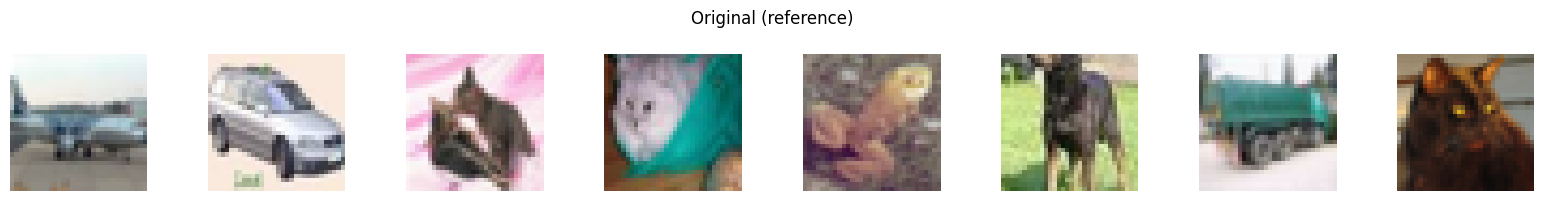

In [1]:
# ----------------------------------------------------------
# Mini-Palette: A Didactic Replication of
# "Palette: Image-to-Image Diffusion Models" (SIGGRAPH 2022)
# ----------------------------------------------------------
# Tasks: Colorization (grayscale → color), Inpainting (fill masked region)
# Key choices aligned with the paper:
#   • Conditional diffusion p(y|x): concatenate x (conditioning image) with noisy y_t
#   • L2 denoising loss (more sample diversity than L1)
#   • Self-attention in U-Net bottleneck (helps quality)
#   • For inpainting: fill mask with Gaussian noise for x; keep unmasked region fixed at sampling
# ----------------------------------------------------------

import math, random, torch, torch.nn as nn, torch.optim as optim
import torchvision, torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ========= 1) Data (CIFAR-10, normalized to [-1,1]) =========
tfm = T.Compose([T.ToTensor(), T.Normalize((0.5,)*3, (0.5,)*3)])
train_set = torchvision.datasets.CIFAR10("./data", train=True,  download=True, transform=tfm)
test_set  = torchvision.datasets.CIFAR10("./data", train=False, download=True, transform=tfm)
train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
classes = train_set.classes

# ========= 2) Schedules & time embedding =========
T_steps = 200
betas = torch.linspace(1e-4, 2e-2, T_steps, device=device)
alphas = 1.0 - betas
alpha_bar = torch.cumprod(alphas, dim=0)
sqrt_ab = torch.sqrt(alpha_bar)
sqrt_om = torch.sqrt(1 - alpha_bar)

def t_embed(t, dim=128):
    half = dim // 2
    freqs = torch.exp(-math.log(10000) * torch.arange(half, device=device) / half)
    args = t[:, None].float() * freqs[None]
    return torch.cat([torch.sin(args), torch.cos(args)], dim=1)

# ========= 3) U-Net (conditional: [x_cond || y_t]) =========
class ResBlock(nn.Module):
    def __init__(self, c, tdim):
        super().__init__()
        self.norm1 = nn.GroupNorm(8, c); self.act = nn.SiLU(); self.conv1 = nn.Conv2d(c, c, 3, 1, 1)
        self.fc_t  = nn.Linear(tdim, c)
        self.norm2 = nn.GroupNorm(8, c); self.conv2 = nn.Conv2d(c, c, 3, 1, 1)
    def forward(self, x, t):
        h = self.conv1(self.act(self.norm1(x)))
        h = h + self.fc_t(t)[:, :, None, None]
        h = self.conv2(self.act(self.norm2(h)))
        return x + h

class AttnBlock(nn.Module):
    def __init__(self, c, heads=4):
        super().__init__()
        self.norm = nn.GroupNorm(8, c)
        self.q = nn.Conv2d(c, c, 1); self.k = nn.Conv2d(c, c, 1); self.v = nn.Conv2d(c, c, 1); self.proj = nn.Conv2d(c, c, 1)
        self.heads = heads
    def forward(self, x):
        b,c,h,w = x.shape
        y = self.norm(x)
        q,k,v = self.q(y), self.k(y), self.v(y)
        q = q.view(b, self.heads, c//self.heads, h*w)
        k = k.view(b, self.heads, c//self.heads, h*w)
        v = v.view(b, self.heads, c//self.heads, h*w)
        attn = torch.softmax((q.transpose(-2,-1) @ k) / math.sqrt(c//self.heads), dim=-1) # (b,heads,HW,HW)
        out = (attn @ v.transpose(-2,-1)).transpose(-2,-1).contiguous().view(b,c,h,w)
        return x + self.proj(out)

class CondUNet(nn.Module):
    # Input channels: cond(3) + noisy y_t(3) = 6
    def __init__(self, in_ch=6, base=128, tdim=128):
        super().__init__()
        self.tproj = nn.Sequential(nn.Linear(tdim, tdim), nn.SiLU(), nn.Linear(tdim, tdim))
        self.inc   = nn.Conv2d(in_ch, base, 3, 1, 1)
        self.d1    = ResBlock(base, tdim)
        self.down1 = nn.Conv2d(base, base*2, 4, 2, 1)       # 32->16
        self.d2    = ResBlock(base*2, tdim)
        self.down2 = nn.Conv2d(base*2, base*2, 4, 2, 1)     # 16->8
        self.mid1  = ResBlock(base*2, tdim)
        self.midA  = AttnBlock(base*2)                      # self-attention at bottleneck
        self.mid2  = ResBlock(base*2, tdim)
        self.up1   = nn.ConvTranspose2d(base*2, base*2, 4, 2, 1)  # 8->16
        self.u1    = ResBlock(base*2, tdim)
        self.up2   = nn.ConvTranspose2d(base*2, base, 4, 2, 1)    # 16->32
        self.u2    = ResBlock(base, tdim)
        self.out   = nn.Conv2d(base, 3, 3, 1, 1)             # predict epsilon in RGB
    def forward(self, x_cat, t_emb):
        t = self.tproj(t_emb)
        h = self.inc(x_cat)
        h = self.d1(h, t)
        h = self.down1(h); h = self.d2(h, t)
        h = self.down2(h); h = self.mid1(h, t); h = self.midA(h); h = self.mid2(h, t)
        h = self.up1(h);   h = self.u1(h, t)
        h = self.up2(h);   h = self.u2(h, t)
        return self.out(h)

model = CondUNet().to(device)
opt = optim.AdamW(model.parameters(), lr=1e-4)

# ========= 4) Task helpers =========
def rgb_to_gray3(x):
    w = torch.tensor([0.299, 0.587, 0.114], device=x.device)[None,:,None,None]
    g = (x * w).sum(1, keepdim=True)
    return g.repeat(1,3,1,1)

def make_rect_mask(B, H=32, W=32):
    m = torch.zeros(B,1,H,W, device=device)
    for b in range(B):
        h = random.randint(H//6, H//2); w = random.randint(W//6, W//2)
        y0 = random.randint(0, H-h); x0 = random.randint(0, W-w)
        m[b, :, y0:y0+h, x0:x0+w] = 1.0
    return m

def q_sample(y0, t, noise=None):
    if noise is None: noise = torch.randn_like(y0)
    a = sqrt_ab[t][:,None,None,None]; b = sqrt_om[t][:,None,None,None]
    return a * y0 + b * noise, noise

# ========= 5) Training (multi-task: colorization OR inpainting per batch) =========
def train(epochs=3):
    model.train()
    for ep in range(epochs):
        run=0.0; n=0
        for x,_ in train_loader:
            x = x.to(device, non_blocking=True)          # y0 (target color)
            B = x.size(0)
            # choose task
            do_inpaint = (random.random() < 0.5)
            if do_inpaint:
                mask = make_rect_mask(B, x.size(2), x.size(3))
                noisy_fill = torch.randn_like(x)
                x_cond = x*(1-mask) + noisy_fill*mask     # fill masked region with noise
                loss_mask = mask                          # compute loss only on masked region
            else:
                x_cond = rgb_to_gray3(x)                  # grayscale as condition
                loss_mask = torch.ones(B,1,x.size(2),x.size(3), device=device)

            # diffusion step
            t = torch.randint(0, T_steps, (B,), device=device, dtype=torch.long)
            y_t, eps = q_sample(x, t)

            # conditional input: concat(cond, noisy target)
            x_cat = torch.cat([x_cond, y_t], dim=1)
            pred = model(x_cat, t_embed(t, 128))

            # L2 denoising loss, optionally masked (inpainting)
            w = loss_mask
            loss = ((pred - eps)**2 * w).sum() / (w.sum()*3 + 1e-8)

            opt.zero_grad(set_to_none=True); loss.backward(); opt.step()
            run += loss.item(); n+=1
        print(f"[Ep {ep+1}/{epochs}] loss={run/n:.4f}")

train(epochs=3)

# ========= 6) Sampling =========
@torch.no_grad()
def sample_colorization(x_color, n_samples=8):
    model.eval()
    x_cond = rgb_to_gray3(x_color)
    B = x_cond.size(0)
    y = torch.randn(B,3,32,32, device=device)
    for t in reversed(range(T_steps)):
        tb = torch.full((B,), t, device=device, dtype=torch.long)
        x_cat = torch.cat([x_cond, y], dim=1)
        eps = model(x_cat, t_embed(tb, 128))
        a_t, ab_t = alphas[t], alpha_bar[t]
        y = (1/torch.sqrt(a_t)) * (y - ((1-a_t)/torch.sqrt(1-ab_t)) * eps)
        if t>0: y = y + torch.sqrt(betas[t]) * torch.randn_like(y)
    return y.clamp(-1,1)

@torch.no_grad()
def sample_inpainting(x_full, mask):
    model.eval()
    x_cond = x_full*(1-mask) + torch.randn_like(x_full)*mask
    B = x_cond.size(0)
    y = torch.randn(B,3,32,32, device=device)
    for t in reversed(range(T_steps)):
        tb = torch.full((B,), t, device=device, dtype=torch.long)
        x_cat = torch.cat([x_cond, y], dim=1)
        eps = model(x_cat, t_embed(tb, 128))
        a_t, ab_t = alphas[t], alpha_bar[t]
        y = (1/torch.sqrt(a_t)) * (y - ((1-a_t)/torch.sqrt(1-ab_t)) * eps)
        if t>0: y = y + torch.sqrt(betas[t]) * torch.randn_like(y)
        # keep unmasked pixels fixed to observed x_full (Palette trick)
        y = y*mask + x_full*(1-mask)
    return y.clamp(-1,1)

# ========= 7) Visualize outputs =========
def show_grid(imgs, title, cols=8):
    imgs = (imgs.detach().cpu()*0.5+0.5).clamp(0,1).numpy()
    r = int(np.ceil(len(imgs)/cols)); plt.figure(figsize=(cols*2, r*2)); plt.suptitle(title)
    for i in range(len(imgs)):
        plt.subplot(r, cols, i+1); plt.imshow(np.transpose(imgs[i], (1,2,0))); plt.axis('off')
    plt.tight_layout(); plt.show()

# Take a small batch from test set
xb,_ = next(iter(DataLoader(test_set, batch_size=8, shuffle=True)))
xb = xb.to(device)

# Colorization demo
y_col = sample_colorization(xb)
show_grid(rgb_to_gray3(xb), "Input (grayscale)")
show_grid(y_col,           "Palette (colorized)")
show_grid(xb,              "Original color (reference)")

# Inpainting demo
mask = make_rect_mask(xb.size(0), xb.size(2), xb.size(3))
y_inp = sample_inpainting(xb, mask)
show_grid(xb*(1-mask),     "Input (masked)")
show_grid(y_inp,           "Palette (inpainted)")
show_grid(xb,              "Original (reference)")


In [2]:
# ==========================================================
# Mini-Palette — Model & Feature Summary as a Table
# (works with the CondUNet you just trained)
# ==========================================================
from dataclasses import dataclass, asdict
import torch, torch.nn as nn

# Optional layer-by-layer table (installs torchinfo if missing)
try:
    from torchinfo import summary as torchinfo_summary
    _HAS_TORCHINFO = True
except Exception:
    _HAS_TORCHINFO = False

# ---- Helpers ----
def _count_params(m: nn.Module):
    total = sum(p.numel() for p in m.parameters())
    trainable = sum(p.numel() for p in m.parameters() if p.requires_grad)
    return total, trainable

@dataclass
class PaletteSummary:
    model_name: str
    parameters_total: int
    parameters_trainable: int
    input_resolution: str
    cond_channels: int
    target_channels: int
    concat_input_channels: int
    base_channels: int
    time_embed_dim: int
    bottleneck_attn: bool
    attn_heads: int | None
    timesteps_T: int
    beta_schedule: str
    loss_type: str
    tasks: str
    sampling_steps: int
    optimizer: str
    dtype: str
    device: str

def summarize_palette(
    palette_model: nn.Module,
    *,
    input_hw=(32, 32),
    cond_ch=3,
    target_ch=3,
    T_steps=200,
    beta_schedule="linear",
    loss_type="L2 (epsilon denoising)",
    tasks=("colorization", "inpainting"),
    sampling_steps=50,
    optimizer_desc="AdamW (lr=1e-4)",
    print_tables=True
) -> PaletteSummary:
    H, W = input_hw
    total, trainable = _count_params(palette_model)

    # infer architecture bits from your CondUNet definition
    in_cat = palette_model.inc.in_channels           # expected concat channels (cond + noisy target)
    base   = palette_model.inc.out_channels
    # time embedding dim from first Linear in tproj
    tdim   = next(m for m in palette_model.tproj.modules() if isinstance(m, nn.Linear)).in_features
    # bottleneck attention (AttnBlock) if present
    has_attn = hasattr(palette_model, "midA")
    heads = getattr(getattr(palette_model, "midA", None), "heads", None)

    ps = PaletteSummary(
        model_name=palette_model.__class__.__name__,
        parameters_total=total,
        parameters_trainable=trainable,
        input_resolution=f"{H}x{W}",
        cond_channels=cond_ch,
        target_channels=target_ch,
        concat_input_channels=in_cat,
        base_channels=base,
        time_embed_dim=tdim,
        bottleneck_attn=has_attn,
        attn_heads=heads,
        timesteps_T=T_steps,
        beta_schedule=beta_schedule,
        loss_type=loss_type,
        tasks=", ".join(tasks),
        sampling_steps=sampling_steps,
        optimizer=optimizer_desc,
        dtype=str(next(palette_model.parameters()).dtype).replace("torch.", ""),
        device=str(next(palette_model.parameters()).device),
    )

    if print_tables:
        # Markdown table
        d = asdict(ps)
        print("## Mini-Palette Feature Table\n")
        print("| Field | Value |")
        print("|---|---|")
        for k, v in d.items():
            print(f"| {k.replace('_',' ')} | {v} |")

        # Optional: layer-by-layer summary with correct inputs (x_cat, t_emb)
        if _HAS_TORCHINFO:
            try:
                x_cat = torch.zeros(1, in_cat, H, W).to(next(palette_model.parameters()).device)
                t_emb = torch.zeros(1, tdim).to(next(palette_model.parameters()).device)
                print("\n### Layer-by-layer (torchinfo)\n")
                torchinfo_summary(
                    model=palette_model,
                    input_data=(x_cat, t_emb),
                    col_names=("input_size", "output_size", "num_params", "trainable"),
                    col_width=20,
                    row_settings=("var_names",),
                )
            except Exception as e:
                print(f"(torchinfo summary skipped: {e})")
        else:
            print("\n(torchinfo not installed; `pip install torchinfo` for a layer table)")

    return ps

# -------------------------
# Usage (works with your `model` from Mini-Palette script):
# ps = summarize_palette(
#     palette_model=model,
#     input_hw=(32,32),
#     cond_ch=3, target_ch=3,
#     T_steps=200, beta_schedule="linear",
#     loss_type="L2 (epsilon denoising)",
#     tasks=("colorization","inpainting"),
#     sampling_steps=50,
#     optimizer_desc="AdamW (lr=1e-4)"
# )
# -------------------------


In [3]:
# === Recall: print Mini-Palette model & feature table ===
# (Run AFTER defining CondUNet; if `model` doesn't exist, we'll instantiate one.)

# 1) Ensure torchinfo (optional, for layer-by-layer table)
try:
    from torchinfo import summary as torchinfo_summary
except Exception:
    !pip install -q torchinfo
    from torchinfo import summary as torchinfo_summary

# 2) Get a palette model
try:
    palette_model = model  # your trained CondUNet
except NameError:
    # fallback: create a fresh CondUNet on the right device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    palette_model = CondUNet().to(device)

# 3) Call the summarizer (this PRINTS the table)
ps = summarize_palette(
    palette_model=palette_model,
    input_hw=(32, 32),
    cond_ch=3,
    target_ch=3,
    T_steps=200,
    beta_schedule="linear",
    loss_type="L2 (epsilon denoising)",
    tasks=("colorization", "inpainting"),
    sampling_steps=50,
    optimizer_desc="AdamW (lr=1e-4)",
    print_tables=True,   # <-- ensures output
)

# (Optional) Quick one-liners:
print("\nTotal params (M):", round(ps.parameters_total/1e6, 3))
print("Has bottleneck attention:", ps.bottleneck_attn, "| heads:", ps.attn_heads)


## Mini-Palette Feature Table

| Field | Value |
|---|---|
| model name | CondUNet |
| parameters total | 8935043 |
| parameters trainable | 8935043 |
| input resolution | 32x32 |
| cond channels | 3 |
| target channels | 3 |
| concat input channels | 6 |
| base channels | 128 |
| time embed dim | 128 |
| bottleneck attn | True |
| attn heads | 4 |
| timesteps T | 200 |
| beta schedule | linear |
| loss type | L2 (epsilon denoising) |
| tasks | colorization, inpainting |
| sampling steps | 50 |
| optimizer | AdamW (lr=1e-4) |
| dtype | float32 |
| device | cuda:0 |

(torchinfo not installed; `pip install torchinfo` for a layer table)

Total params (M): 8.935
Has bottleneck attention: True | heads: 4
